# Techpro DataScience Bootcamp First Machnine Learning Project

- 15.07.2023 - Nurullah Cildag

- Bu mini projede, arabaların CO2 emisyonlarını tahmin etmek için hem Statsmodel hem de Scikit-learn'de SLR ve MLR modelleri oluşturacaksınız. 



- SLR yaparken Engine Size(L) ve CO2 Emissions(g/km) columnlarını kullanacaksınız.



- MLR Engine Size(L), Fuel Consumption Comb (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption City (L/100 km), CO2 Emissions(g/km) columnlarını kullanacaksınız.



- Sanırım Target ve Featureleri kendiniz bulabilirsiniz.



- Bunun haricinde Regularization derslerinde gördüğümüz (Scale, Cross Validation, Ridge-Lasso Regression Elastic Net, Grid Search) tüm parametrelerle skorlarımızı iyileştirelim

In [38]:
!pip install plotly
!pip install dash
!pip install wordcloud
!pip install cufflinks
!pip install missingno
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install yellowbrick

In [39]:
#Importing the required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# if you would like to create all your charts with same size --> plt.rcParams["figure.figsize"] = (10, 6)

#%matplotlib inline
#plt.style.use('ggplot')
# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')


In [40]:
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #as model olur fakat literatür
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

## Explaratory Data Analysis

### Load Dataset

In [41]:
df = pd.read_csv("co2.csv")
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


### Feature Information

**Make:** Vehicle brand

**Model:** Vehicle model
- 4WD/4X4 = Four-wheel drive

- AWD = All-wheel drive

- FFV = Flexible-fuel vehicle

- SWB = Short wheelbase

- LWB = Long wheelbase

- EWB = Extended wheelbase


**Vehicle Class:** Vehicle class (e.g. small car, sports car, van, etc.)

**Engine Size (L):** Vehicle engine displacement (in liters)

**Cylinders:** Number of vehicle cylinders

**Transmission:** Vehicle gearbox type (manual or automatic)
- A = Automatic

- AM = Automated manual

- AS = Automatic with select shift

- AV = Continuously variable

- M = Manual

- 3 - 10 = Number of gears

**Fuel Type:** Type of fuel used (e.g. gasoline, diesel, hybrid, etc.)
- X = Regular gasoline

- Z = Premium gasoline

- D = Diesel

- E = Ethanol (E85)

- N = Natural gas

**Fuel Consumption City (L/100 km):** Fuel consumption city (liters/100 km)

**Fuel Consumption Hwy (L/100 km):** Hwy fuel consumption (liters/100 km)

**Fuel Consumption Comb (L/100 km):** Average fuel consumption (liters/100 km)

**Fuel Consumption Comb (mpg):** Fuel economy (miles per gallon)
- City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per gallon (mpg)

**CO2 Emissions (g/km):** CO2 emissions per vehicle (grams/kilometer)

In [42]:
def get_unique_values(df):
    
    output_data = []

    for col in df.columns:

        # If the number of unique values in the column is less than or equal to 5
        if df.loc[:, col].nunique() <= 10:
            # Get the unique values in the column
            unique_values = df.loc[:, col].unique()
            # Append the column name, number of unique values, unique values, and data type to the output data
            output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        else:
            # Otherwise, append only the column name, number of unique values, and data type to the output data
            output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

    output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

    return output_df

In [43]:
get_unique_values(df)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,Make,42,-,object
1,Model,2053,-,object
2,Vehicle Class,16,-,object
3,Engine Size(L),51,-,float64
4,Cylinders,8,"[4, 6, 12, 8, 10, 3, 5, 16]",int64
5,Transmission,27,-,object
6,Fuel Type,5,"[Z, D, X, E, N]",object
7,Fuel Consumption City (L/100 km),211,-,float64
8,Fuel Consumption Hwy (L/100 km),143,-,float64
9,Fuel Consumption Comb (L/100 km),181,-,float64


In [44]:
df.sample(5)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
2207,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,28,235
5055,LEXUS,NX 300 AWD F SPORT,SUV - SMALL,2.0,4,AS6,Z,10.8,8.9,9.9,29,232
6627,BMW,X4 M,SUV - SMALL,3.0,6,AS8,Z,16.6,12.1,14.6,19,339
6782,FORD,Edge AWD,SUV - SMALL,2.7,6,AS8,X,12.5,9.2,11.0,26,258
3907,JEEP,PATRIOT,SUV - SMALL,2.4,4,M5,X,10.2,8.3,9.3,30,219


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

### Null Value Check

In [46]:
# There is no null data here.

In [47]:
df.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [48]:
import missingno as msno

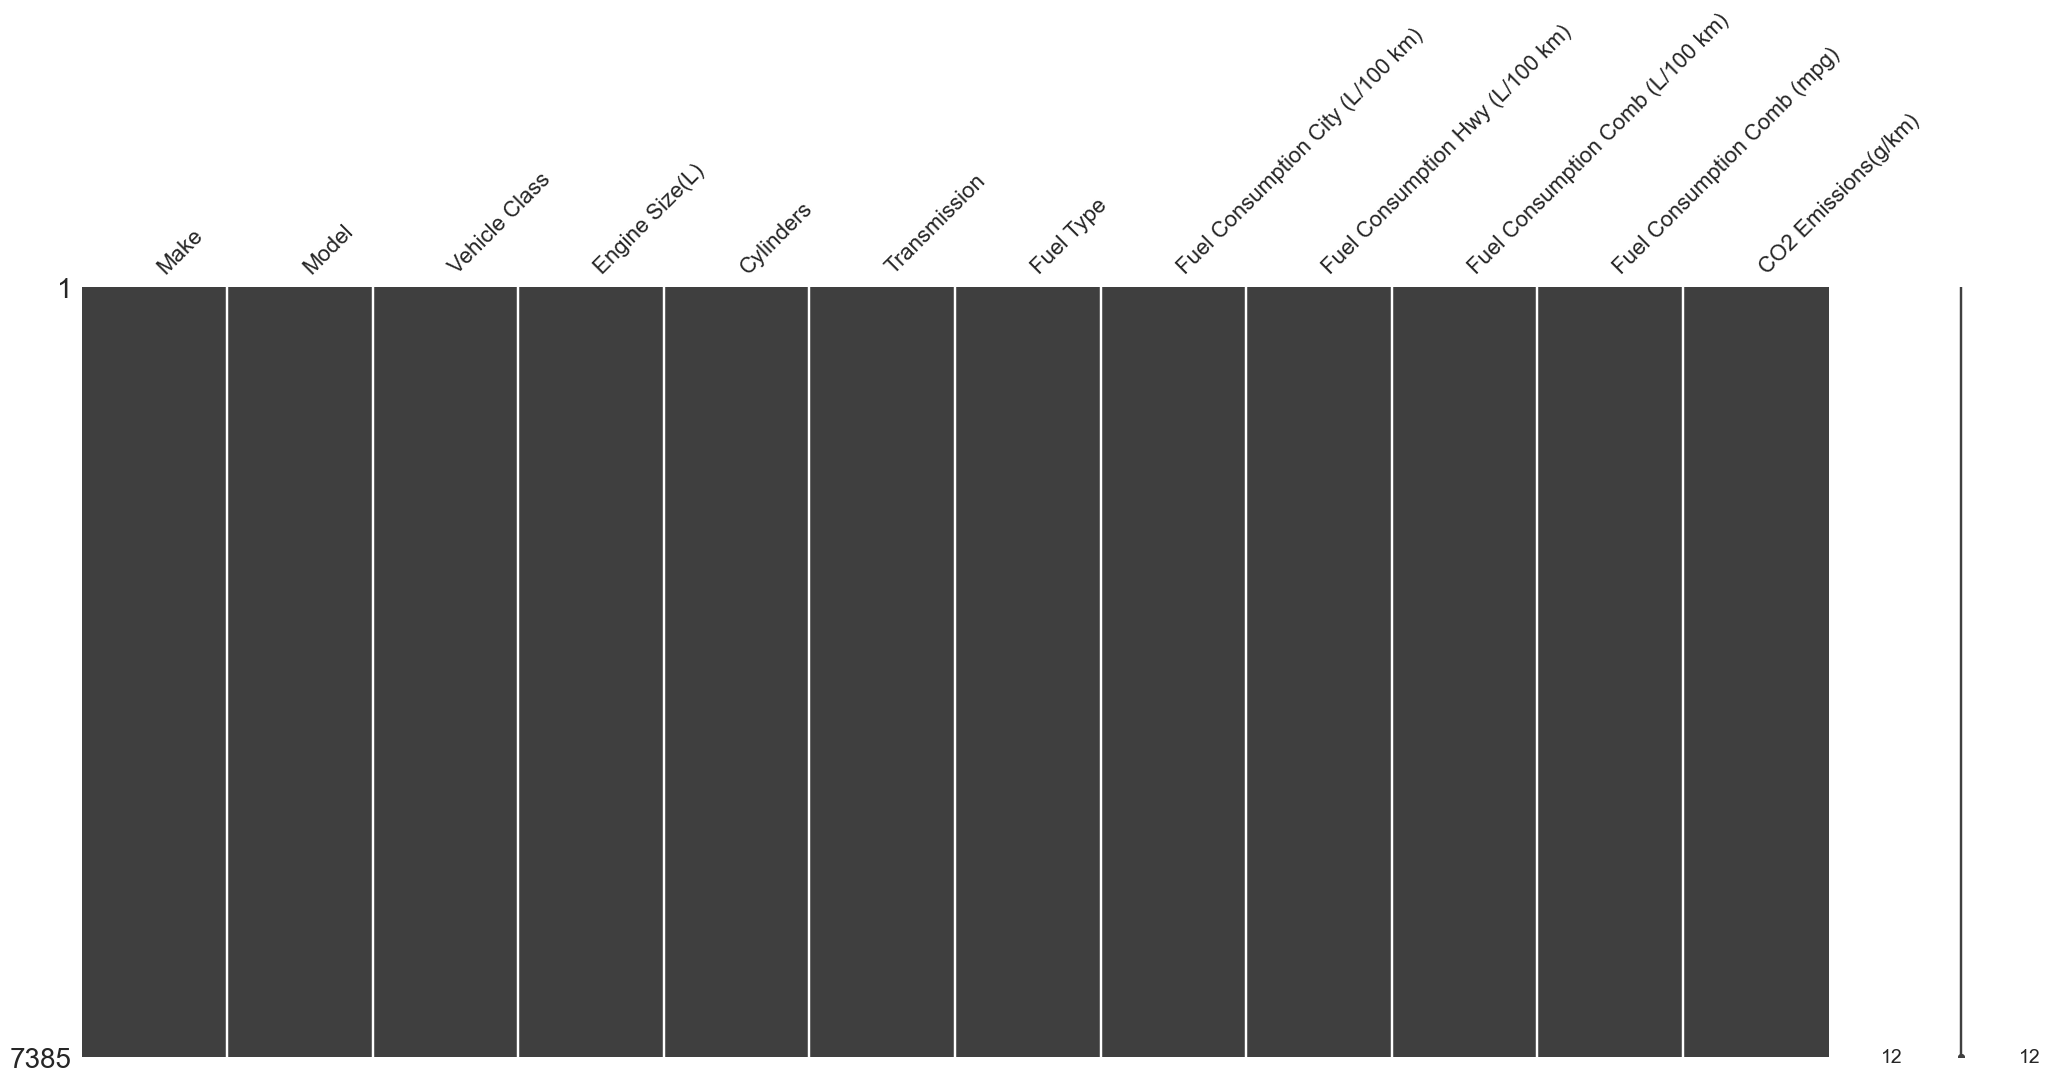

In [49]:
msno.matrix(df);

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Engine Size(L),7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
Cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
Fuel Consumption City (L/100 km),7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
Fuel Consumption Hwy (L/100 km),7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
Fuel Consumption Comb (L/100 km),7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
Fuel Consumption Comb (mpg),7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
CO2 Emissions(g/km),7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


In [51]:
df.corr()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
Engine Size(L),1.000000,0.927653,0.831379,0.761526,0.817060,-0.757854,0.851145
Cylinders,0.927653,1.000000,0.800702,0.715252,0.780534,-0.719321,0.832644
Fuel Consumption City (L/100 km),0.831379,0.800702,1.000000,0.948180,0.993810,-0.927059,0.919592
Fuel Consumption Hwy (L/100 km),0.761526,0.715252,0.948180,1.000000,0.977299,-0.890638,0.883536
Fuel Consumption Comb (L/100 km),0.817060,0.780534,0.993810,0.977299,1.000000,-0.925576,0.918052
Fuel Consumption Comb (mpg),-0.757854,-0.719321,-0.927059,-0.890638,-0.925576,1.000000,-0.907426
CO2 Emissions(g/km),0.851145,0.832644,0.919592,0.883536,0.918052,-0.907426,1.000000


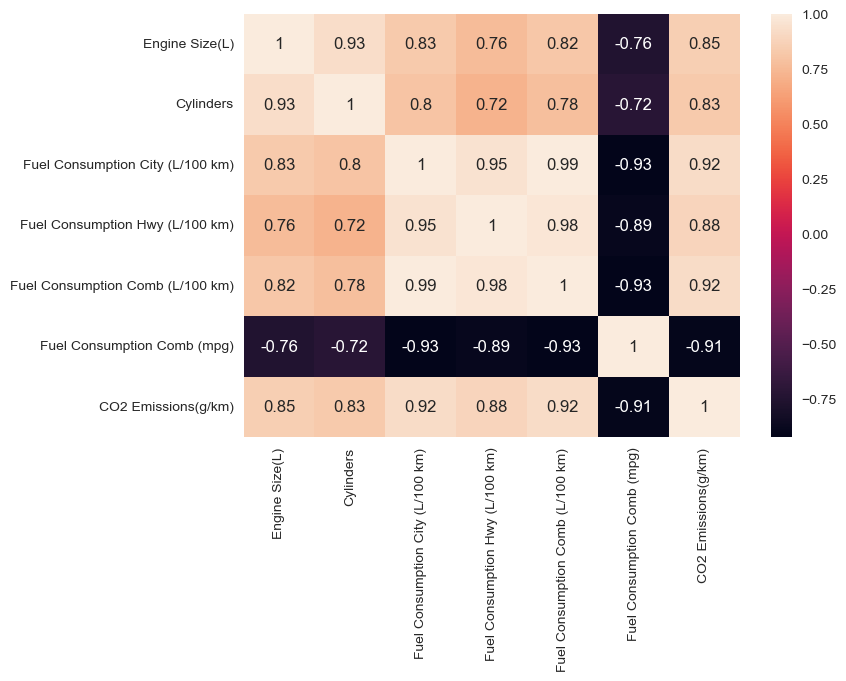

In [52]:
sns.heatmap(df.corr(), annot = True);

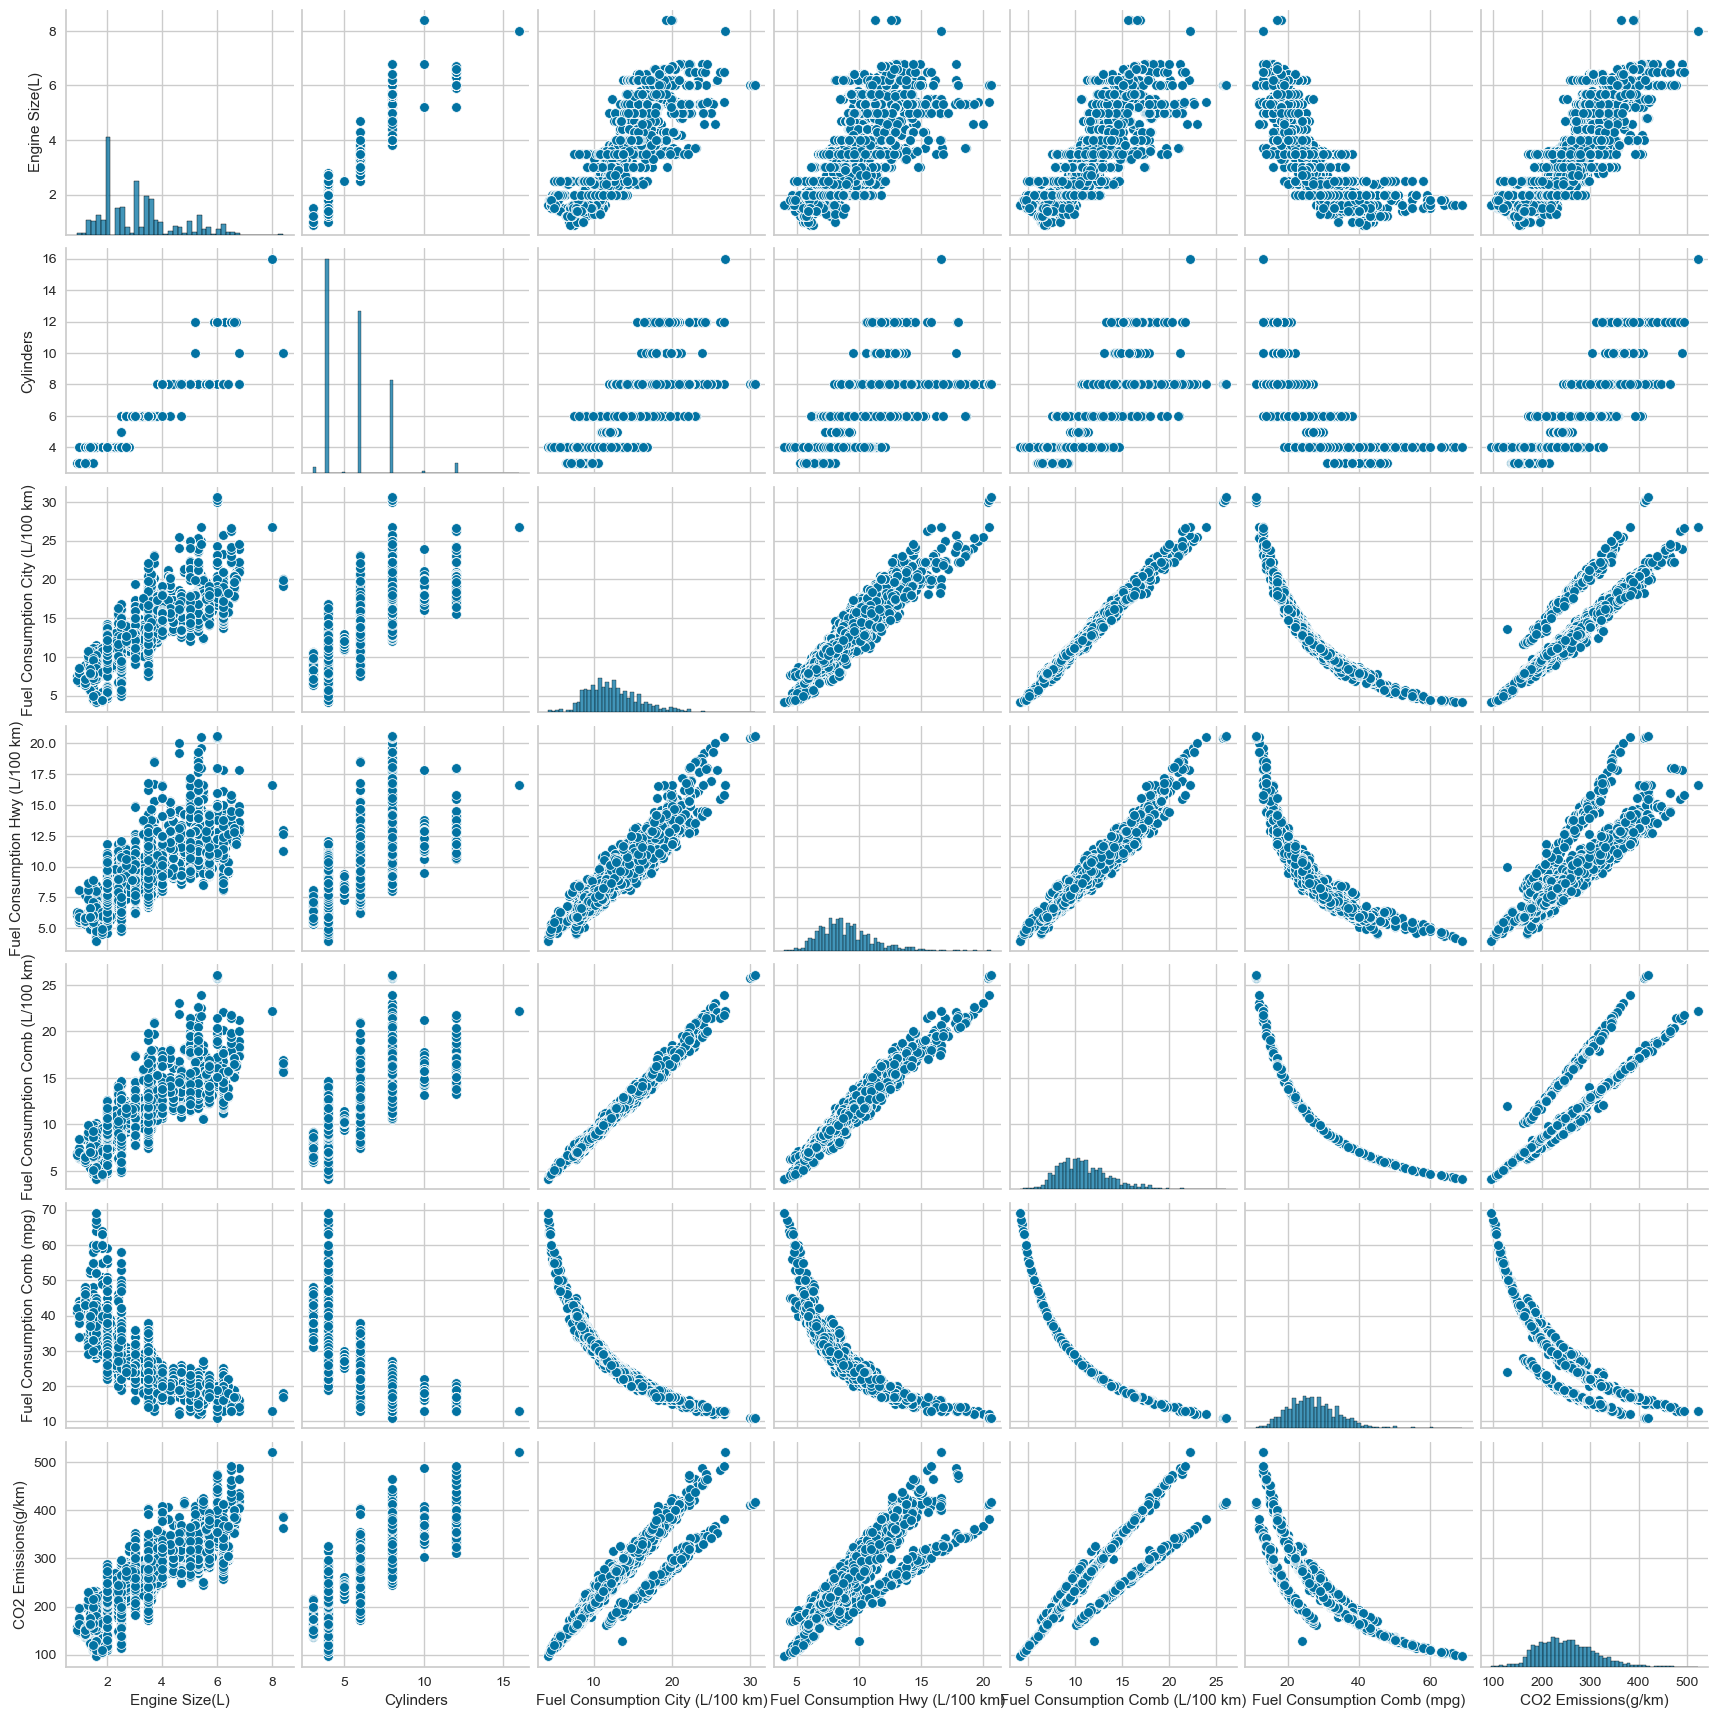

In [53]:
sns.pairplot(df);

### Column Names

In [54]:
# Columnslara bakalim;
df.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'],
      dtype='object')

In [55]:
# let's edit column names
renamed_columns = {
    'Make' : "make",
    'Model' : 'model',
    'Vehicle Class': 'vehicle_class',
    'Engine Size(L)': 'engine_size',
    'Cylinders': 'cylinders',
    'Transmission' : 'transmission',
    'Fuel Type': 'fuel_type',
    'Fuel Consumption City (L/100 km)': 'fuel_cons_city',
    'Fuel Consumption Hwy (L/100 km)': 'fuel_cons_hwy',
    'Fuel Consumption Comb (L/100 km)': 'fuel_cons_comb',
    'Fuel Consumption Comb (mpg)': 'mpgfuel_cons_comb',
    'CO2 Emissions(g/km)': 'co2' }
df.rename(renamed_columns, axis='columns', inplace=True)

In [56]:
#Having a backup from dataset
 
df_new = df.copy()

In [57]:
# Columnslara bakalim;
df.columns

Index(['make', 'model', 'vehicle_class', 'engine_size', 'cylinders',
       'transmission', 'fuel_type', 'fuel_cons_city', 'fuel_cons_hwy',
       'fuel_cons_comb', 'mpgfuel_cons_comb', 'co2'],
      dtype='object')

In [58]:
df.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


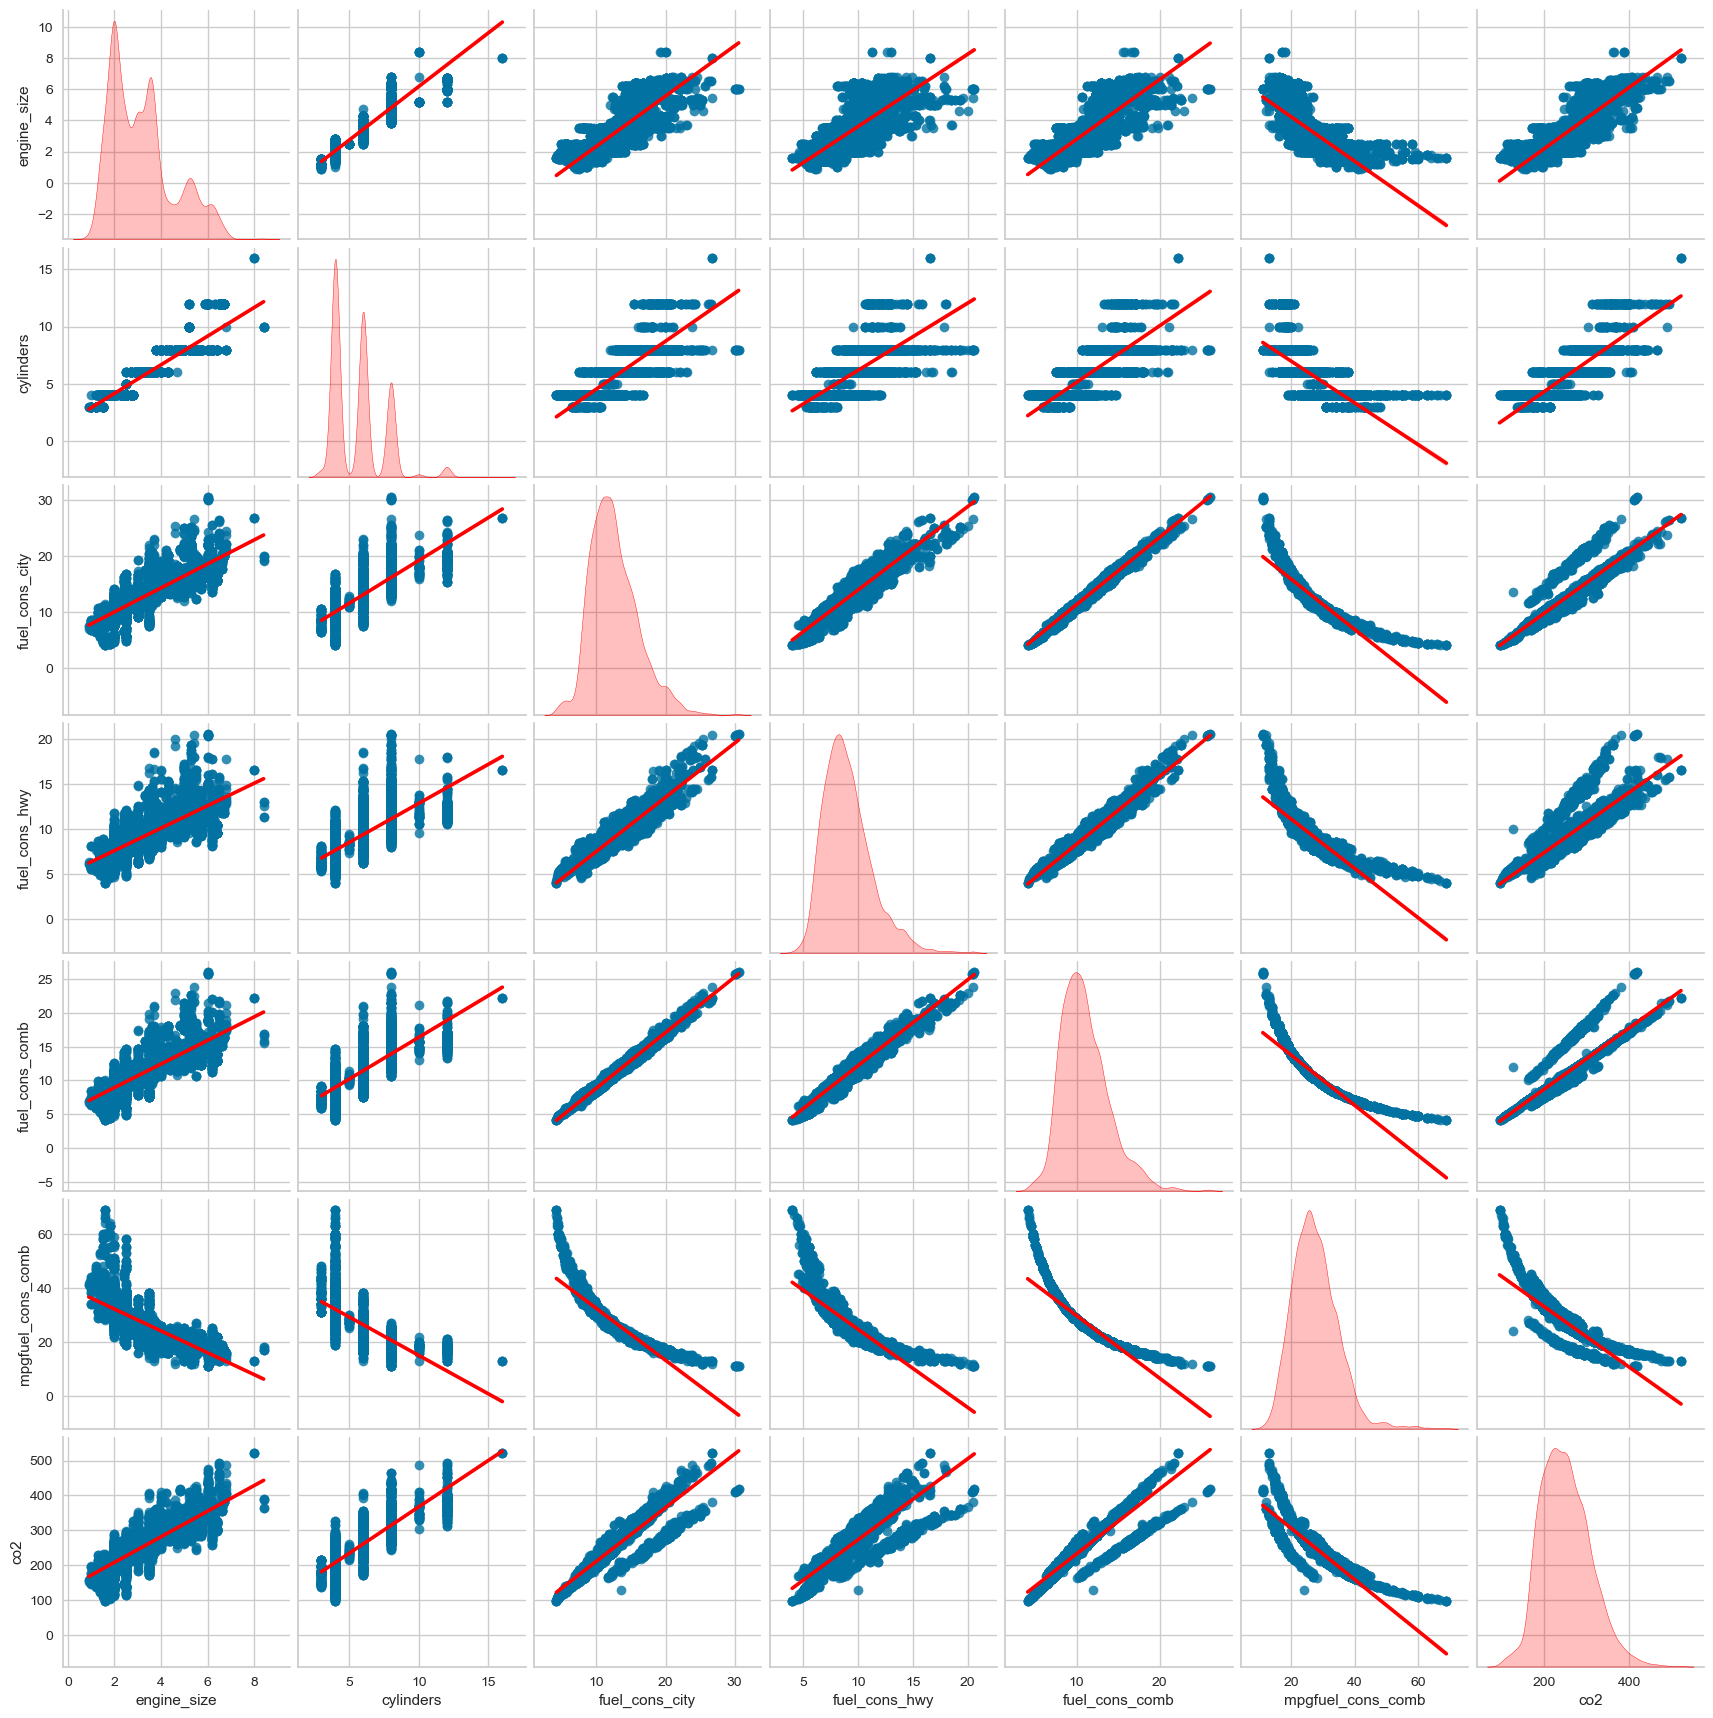

In [59]:
sns.pairplot(df, kind = "reg", diag_kind = "kde", diag_kws={"color":"red"}, plot_kws={"line_kws":{"color":"red"}});

### Outlier Check

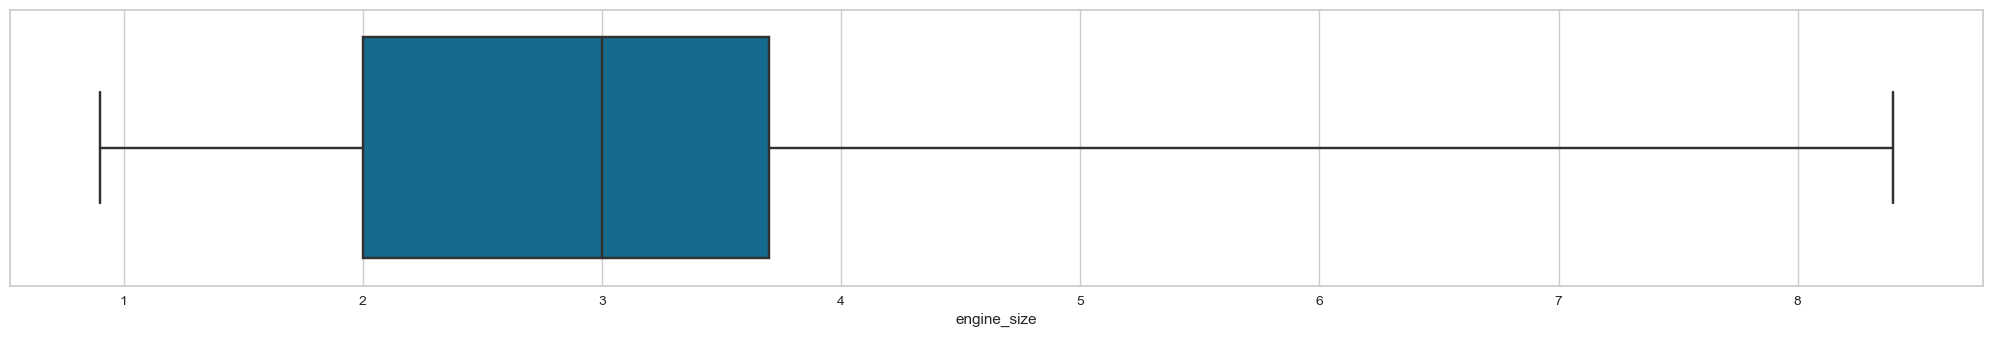

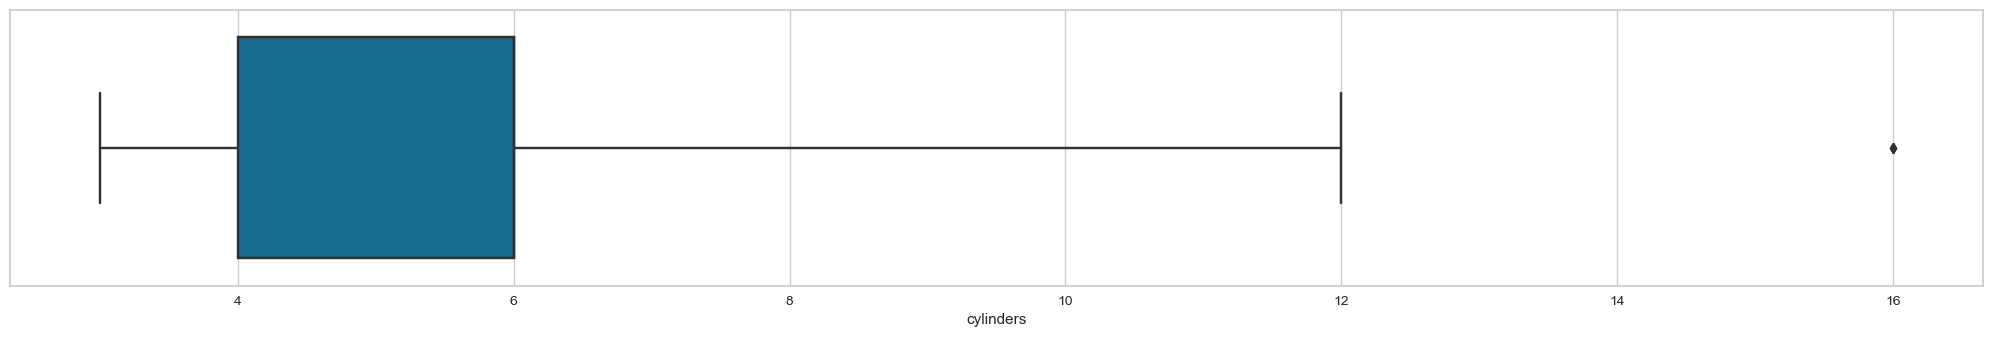

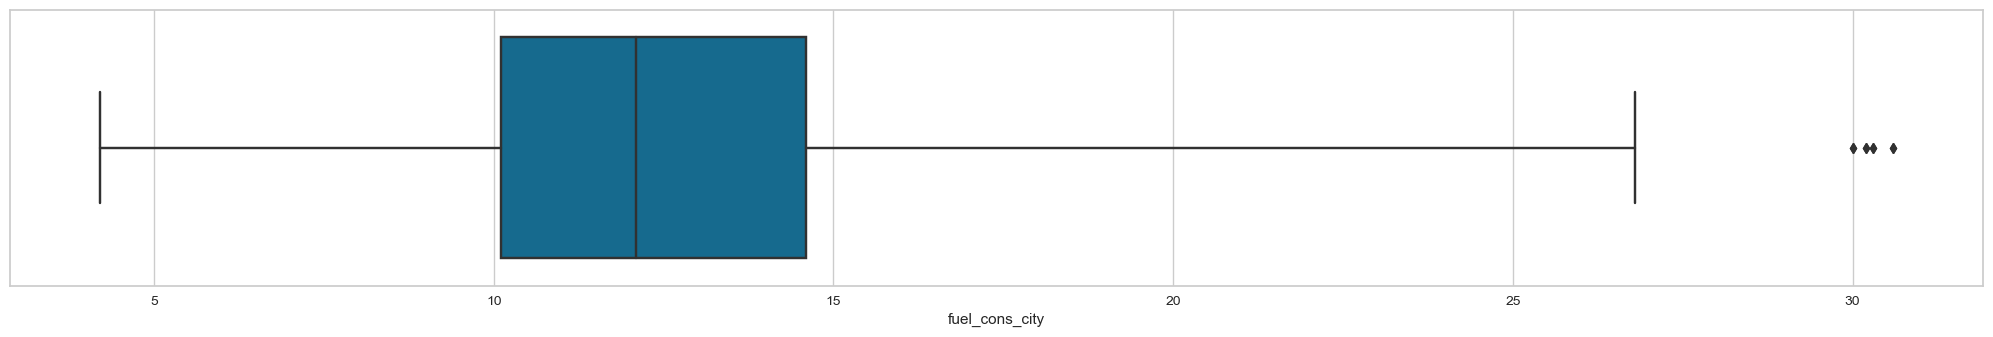

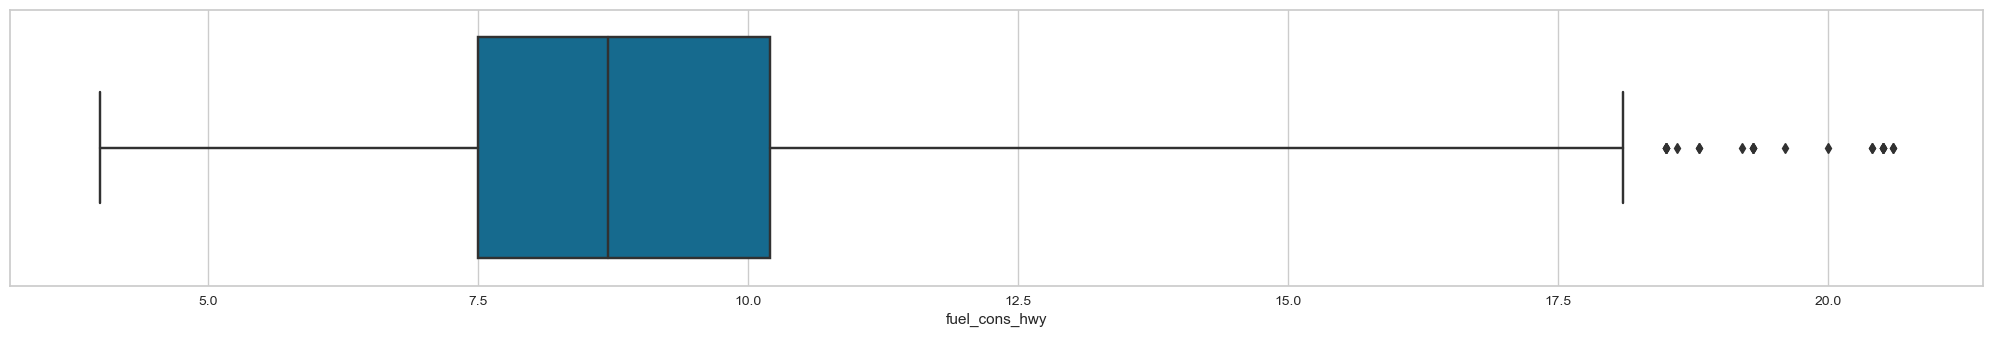

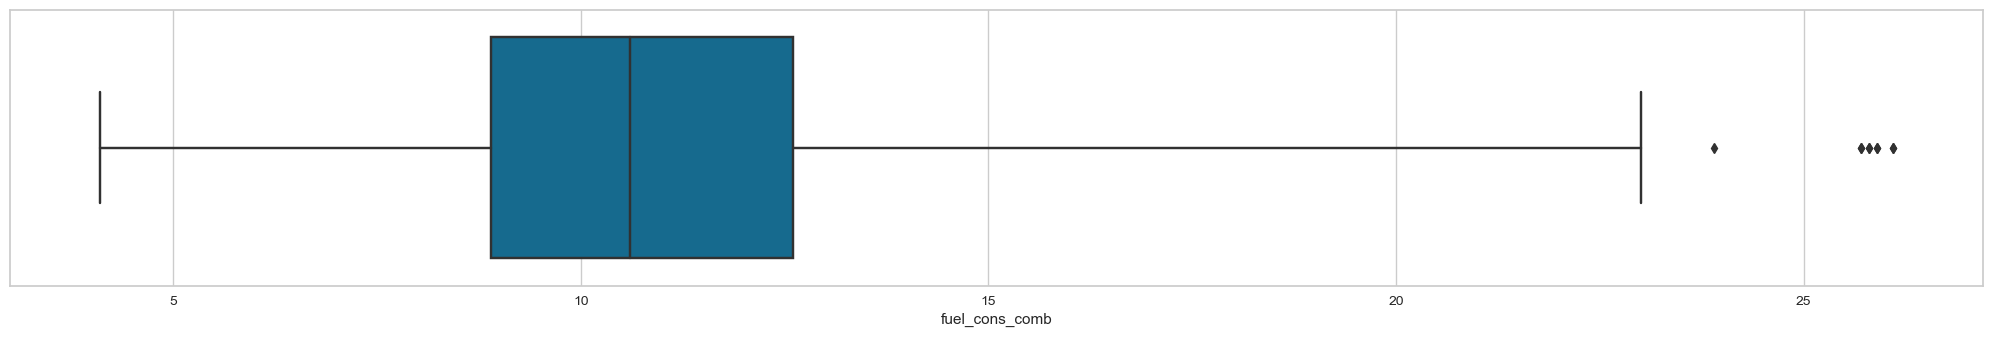

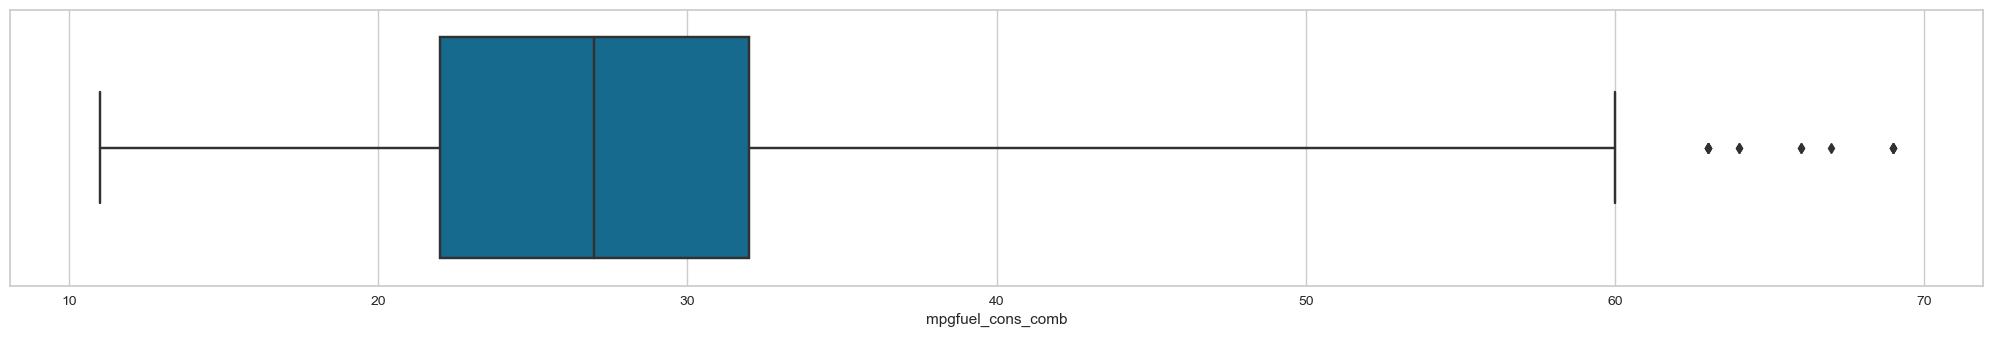

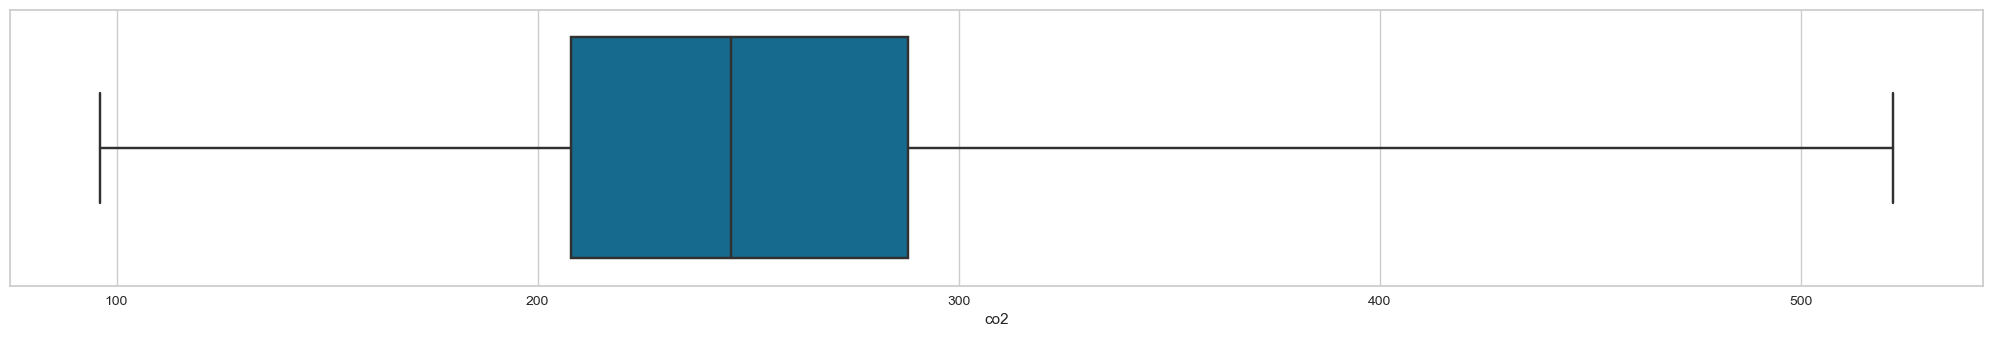

In [60]:
# Let's draw boxplots and histplots for checking distributions of features;

index=0

for feature in df.select_dtypes('number').columns:
    index+=1
    plt.figure(figsize=(40,40))
    plt.subplot((len(df.columns)),2,index)
    sns.boxplot(x=feature,data=df,whis=3) 
        
    plt.tight_layout()
    
    plt.show()

## Simple Linear Regression

In [61]:
# Use Engine Size(L)--> X ve CO2 Emissions(g/km) (y) columnlarını kullanacaksınız.

In [62]:
#New Dataset

slr_df = df[["engine_size", "co2"]]
slr_df.head()

,engine_size,co2
0,2.0,196
1,2.4,221
2,1.5,136
3,3.5,255
4,3.5,244


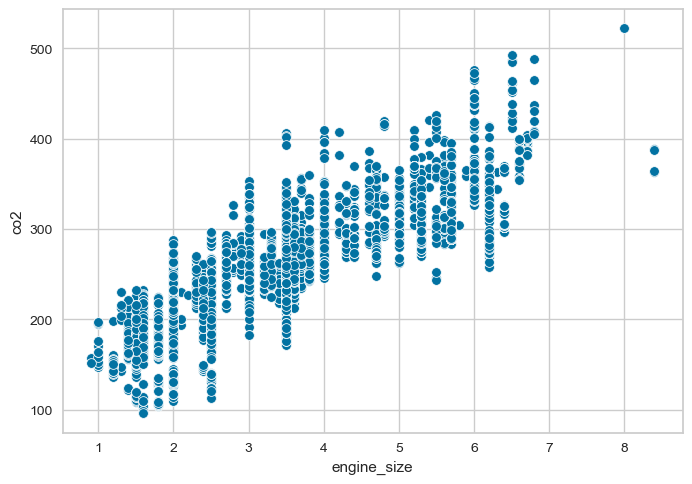

In [63]:
sns.scatterplot(x = "engine_size", y = "co2", data=slr_df);

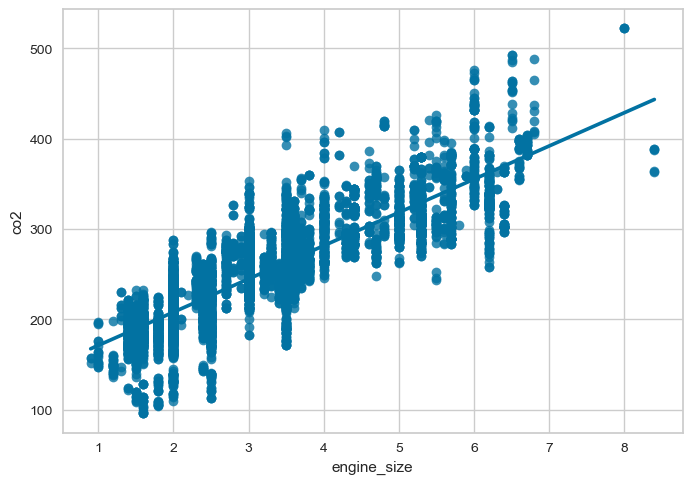

In [64]:
# Linear Regression

sns.regplot(x = "engine_size", y = "co2", data=slr_df, ci=None);

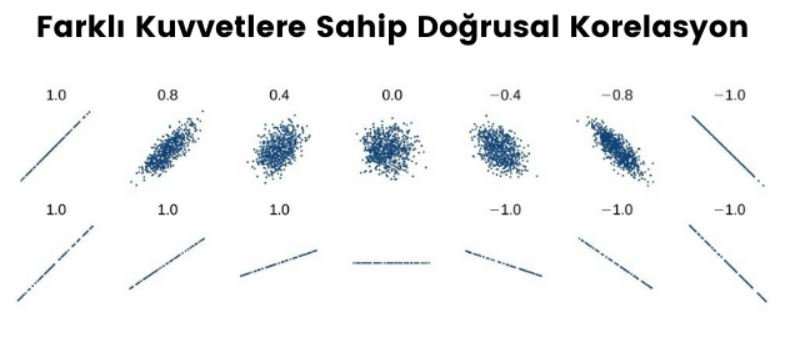

y = b1 * X +b0

y = Target = dependent variable

b1 = Katsayı/eğim, slope 

X = Feature(s), bağımsız değişken, independent variable

b0 = Intercept, otonom parametre, başlangıç parametresi

In [82]:
X = slr_df[["engine_size"]]          # Feature
y = slr_df["co2"]                    # Target

### Train / Test Data Split

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

- Data 1000'e kadar (row 1000'e kadarsa) %70 Train, %30 Test (Train için En düşük bu olmalı)

- Data 1000 - 100.000 ler arasında ise %90-80 Train %10-20 Test

- Data 100.000 - 1.000.000 lar arasında ise %95 Train %5 Test

- Data milyonlar üzerinde ise %99 Train, %1 Test olarak bölünse iyi olur

### Scaling Data

In [85]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()

In [86]:
scaler.fit(X_train)  

StandardScaler()

In [87]:
X_train_scaled = scaler.transform(X_train)  
X_train_scaled 

array([[-0.12149345],
       [ 0.6141664 ],
       [-0.12149345],
       ...,
       [ 0.24633648],
       [-0.48932338],
       [ 0.6141664 ]])

In [88]:
X_test_scaled = scaler.transform(X_test) 
X_test_scaled

array([[-0.12149345],
       [ 0.90843035],
       [ 2.23261809],
       ...,
       [-1.29854922],
       [ 0.24633648],
       [-0.85715331]])

In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
lin_reg = LinearRegression()

In [91]:
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [92]:
lin_reg.intercept_ # b0

250.93957345971563

In [93]:
lin_reg.coef_      # b1

array([49.76780749])

In [95]:
# Assign them to B0 and B1
b0 = lin_reg.intercept_
b1 = lin_reg.coef_

y = 250.93 + 49.76 * X ..........................................(1)

CO2 = 250.93  + 49.76 * "engine_size" ............................(1)

In [96]:
y_train_pred =  b0 + b1 * X_train_scaled
y_train_pred

array([[244.89311066],
       [281.5052888 ],
       [244.89311066],
       ...,
       [263.19919973],
       [226.58702159],
       [281.5052888 ]])

In [97]:
# We will use this code instead of above given equality
y_train_pred = lin_reg.predict(X_train_scaled)
y_train_pred

array([244.89311066, 281.5052888 , 244.89311066, ..., 263.19919973,
       226.58702159, 281.5052888 ])

In [111]:
y_test_pred = lin_reg.predict(X_test_scaled)
y_test_pred

array([244.89311066, 296.15016006, 362.05208072, ..., 186.31362563,
       263.19919973, 208.28093252])

### Check the success of the model with eval_metric

In [98]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [99]:
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    #print("Model testing performance:")
    print("---------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
    
print("Model testing performance for TRAIN DATA:")   
eval_metric(y_train, y_train_pred)

Model testing performance for TRAIN DATA:
---------------------------------------
R2_score 	: 0.7245276280573063
MAE 		: 23.374986568616432
MSE 		: 941.7163581594915
RMSE 		: 30.687397383282466


In [112]:
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    #print("Model testing performance:")
    print("----------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
    
print("Model testing performance for TEST DATA:")   
eval_metric(y_test, y_test_pred)

Model testing performance for TEST DATA:
----------------------------------------
R2_score 	: 0.7238115822302345
MAE 		: 22.92717713434206
MSE 		: 949.9852533375359
RMSE 		: 30.82183079146234


#### Cross Validation

In [103]:
from sklearn.model_selection import cross_validate, cross_val_score

In [104]:
model = LinearRegression()
scores = cross_validate(model, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

In [106]:
pd.DataFrame(scores, index = range(1,11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.004986,0.004987,0.721253,-23.779432,-956.616360,-30.929215
2,0.000996,0.002992,0.693839,-23.571734,-920.157531,-30.334098
3,0.000993,0.002993,0.711604,-24.623101,-1059.180529,-32.545054
4,0.000998,0.001992,0.697387,-23.043243,-924.556910,-30.406527
5,0.000997,0.000997,0.754547,-22.497164,-857.840712,-29.288918
6,0.000996,0.001994,0.712337,-23.154575,-932.875376,-30.543009
7,0.000998,0.000997,0.747016,-22.728297,-910.888084,-30.180923
8,0.000987,0.000997,0.729633,-23.277945,-951.682304,-30.849349
9,0.001000,0.001995,0.707496,-23.459225,-945.678333,-30.751883
10,0.001992,0.000998,0.750757,-23.751550,-968.664775,-31.123380


In [108]:
# Get the average

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                               0.722587
test_neg_mean_absolute_error        -23.388626
test_neg_mean_squared_error        -942.814091
test_neg_root_mean_squared_error    -30.695236
dtype: float64

In [113]:
print("Simple Linear Model testing performance for TRAIN DATA:")
print(eval_metric(y_train, y_train_pred))

print("---------------------------------------")

print("Simple LinearModel testing performance for TEST DATA:")
print(eval_metric(y_test, y_test_pred))

Simple Linear Model testing performance for TRAIN DATA:
----------------------------------------
R2_score 	: 0.7245276280573063
MAE 		: 23.374986568616432
MSE 		: 941.7163581594915
RMSE 		: 30.687397383282466
None
---------------------------------------
Simple LinearModel testing performance for TEST DATA:
----------------------------------------
R2_score 	: 0.7238115822302345
MAE 		: 22.92717713434206
MSE 		: 949.9852533375359
RMSE 		: 30.82183079146234
None


In [114]:
def train_val(y_train, y_train_pred, y_test, y_pred, i):
    
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [115]:
simple_linear = train_val(y_train, y_train_pred, y_test, y_test_pred, "simple")
simple_linear

,simple_train,simple_test
R2,0.724528,0.723812
mae,23.374987,22.927177
mse,941.716358,949.985253
rmse,30.687397,30.821831


Based on above investigation our success rate is 72%.

In [117]:
my_dict = {"Actual": y_test, "pred": y_test_pred, "residual": y_test - y_test_pred}
compare = pd.DataFrame(my_dict)
compare.head(20)

,Actual,pred,residual
7261,253,244.893111,8.106889
4489,344,296.150160,47.849840
1539,322,362.052081,-40.052081
3532,297,329.101120,-32.101120
6418,308,281.505289,26.494711
3703,406,263.199200,142.800800
5976,242,244.893111,-2.893111
4332,216,208.280933,7.719067
5015,246,222.925804,23.074196
2087,223,226.587022,-3.587022


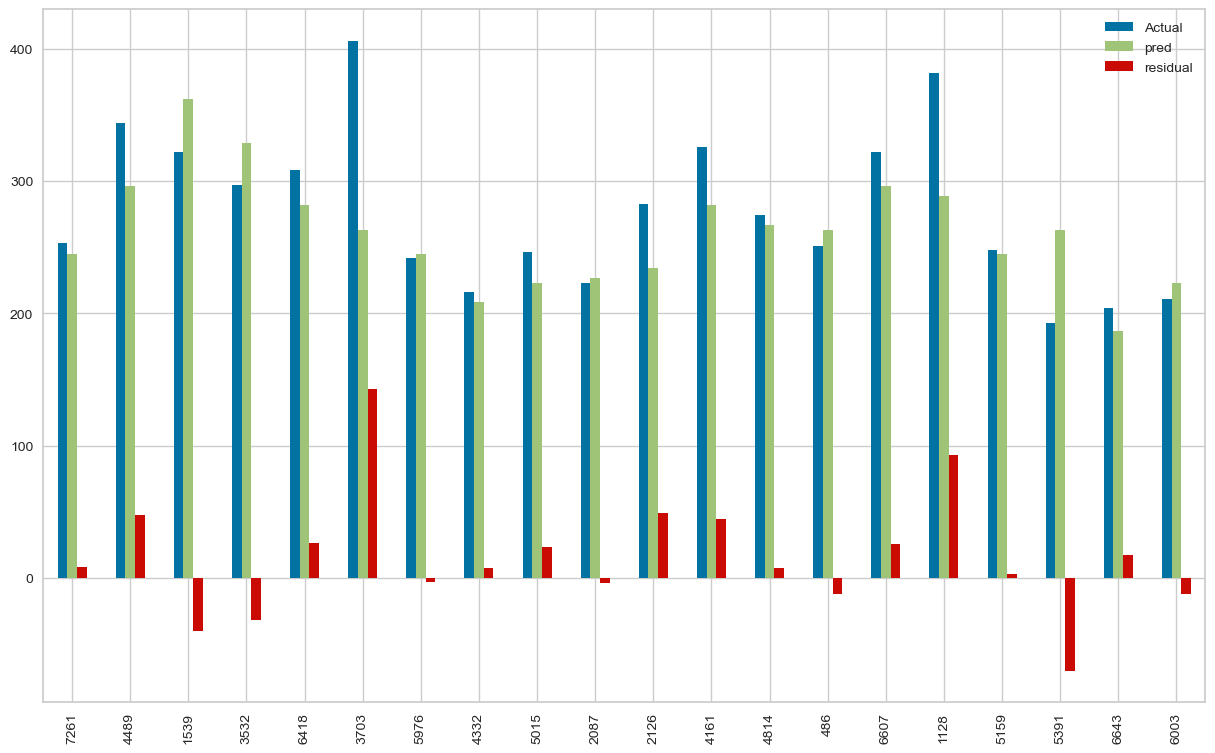

In [118]:
compare.head(20).plot(kind="bar", figsize = (15,9))
plt.show()

In [119]:
residual = y_test - y_test_pred
residual

7261     8.106889
4489    47.849840
1539   -40.052081
3532   -32.101120
6418    26.494711
          ...    
7185    12.719067
1740    51.719067
4609    -2.313626
1844   -28.199200
5154   -15.280933
Name: co2, Length: 1477, dtype: float64

In [120]:
residual.sum().round()

-1247.0

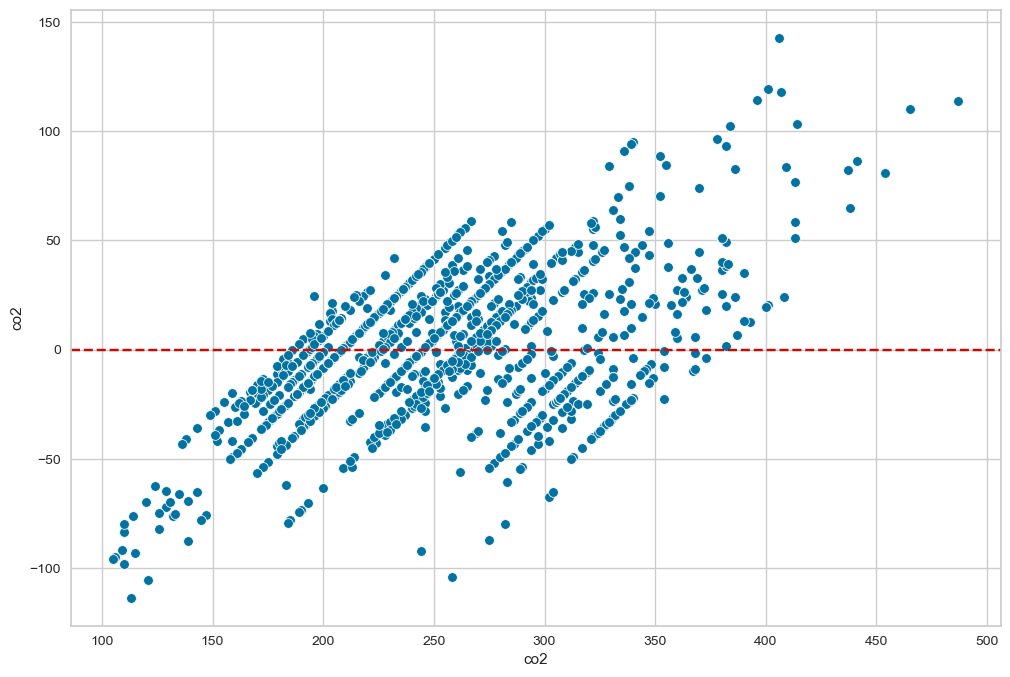

In [121]:

plt.figure(figsize = (12,8))
sns.scatterplot(x=y_test, y=residual)
plt.axhline(y=0, color="r", linestyle = "--")
plt.show()

In [122]:
from yellowbrick.regressor import ResidualsPlot

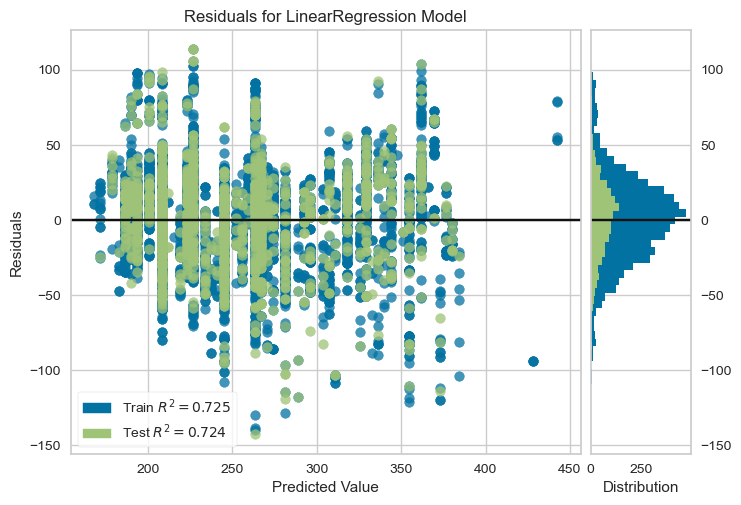

In [123]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

Residuasls are far away from 0 line. That shows us success rate is low.

In [125]:
from yellowbrick.regressor import PredictionError

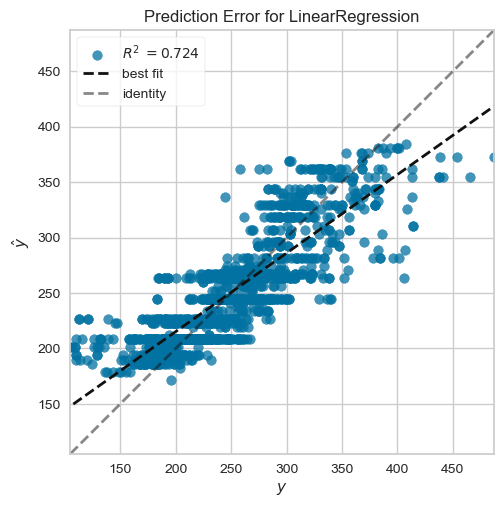

In [124]:
model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

## Multiple Linear Regression

Features;
- Engine Size (L)
- Fuel Consumption City (L/100 km) 
- Fuel Consumption Hwy (L/100 km) 
- Fuel Consumption Comb (L/100 km)  

Target; 

- Emissions(g/km)

Target model; 

** y = b0 + b1*X1 + b2*X2 + b3*X3 + b4*X4

**CO2 = b0 + b1*"engine_size" + b2*'fuel_cons_city' + b3*'fuel_cons_hwy' + b4*'fuel_cons_comb'

In [126]:
X = df[["engine_size", "fuel_cons_city", "fuel_cons_hwy", "fuel_cons_comb"]]
y = df["co2"]

### Train / Test Data Split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [128]:
from sklearn.preprocessing import StandardScaler

In [129]:
scaler = StandardScaler()

In [130]:
scaler.fit(X_train)

StandardScaler()

In [131]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-0.12149345, -0.33509065, -0.42937884, -0.37681659],
       [ 0.6141664 ,  0.6072775 ,  0.56440556,  0.59257065],
       [-0.12149345,  0.350268  , -0.02283068,  0.24636092],
       ...,
       [ 0.24633648, -0.24942082, -0.11317471, -0.20371173],
       [-0.48932338, -0.87766626, -0.74558297, -0.82688924],
       [ 0.6141664 ,  0.23604156,  0.47406152,  0.31560287]])

In [132]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-0.12149345, -0.04952455, -0.02283068, -0.03060686],
       [ 0.90843035,  1.34974937,  1.1516418 ,  1.2849901 ],
       [ 2.23261809,  1.00707004,  1.06129776,  1.04264329],
       ...,
       [-1.29854922, -1.07756253, -1.10695912, -1.10385702],
       [ 0.24633648, -0.1923076 , -0.38420683, -0.27295367],
       [-0.85715331, -0.84910965, -1.10695912, -0.96537313]])

In [133]:
from sklearn.linear_model import LinearRegression

In [134]:
mul_lin_reg = LinearRegression()  

In [135]:

mul_lin_reg.fit(X_train_scaled, y_train) 

LinearRegression()

In [136]:
y_train_pred = mul_lin_reg.predict(X_train_scaled)
y_train_pred

array([234.21340724, 285.16105202, 259.19044914, ..., 246.8490547 ,
       209.34893743, 273.57965294])

In [137]:
y_test_pred = mul_lin_reg.predict(X_test_scaled)
y_test_pred

array([247.46242188, 318.00782197, 330.68063281, ..., 184.91772376,
       244.98292627, 198.69080316])

In [138]:
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    #print("Model testing performance:")
    print("---------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
    
print("Model testing performance for TRAIN DATA:")   
eval_metric(y_train, y_train_pred)

Model testing performance for TRAIN DATA:
---------------------------------------
R2_score 	: 0.8742483641261991
MAE 		: 13.448848226089455
MSE 		: 429.88838311636425
RMSE 		: 20.733749856607325


In [139]:
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    #print("Model testing performance:")
    print("----------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
    
print("Model testing performance for TEST DATA:")   
eval_metric(y_test, y_test_pred)

Model testing performance for TEST DATA:
----------------------------------------
R2_score 	: 0.8713608880187578
MAE 		: 13.519154447456026
MSE 		: 442.4706161519342
RMSE 		: 21.03498552773294


### Cross Validation

In [140]:
model = LinearRegression()
scores = cross_validate(model, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

In [141]:
pd.DataFrame(scores, index = range(1,11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.004987,0.002992,0.869205,-13.739786,-448.866468,-21.186469
2,0.002993,0.003989,0.874288,-12.853381,-377.823054,-19.437671
3,0.003000,0.002984,0.872704,-13.885354,-467.513717,-21.622066
4,0.003989,0.003990,0.859309,-13.398961,-429.844668,-20.732696
5,0.003991,0.002992,0.859484,-14.101987,-491.092260,-22.160602
6,0.002990,0.002991,0.855050,-13.669038,-470.066559,-21.681018
7,0.002995,0.002991,0.896184,-12.855013,-373.795711,-19.333797
8,0.001994,0.002992,0.880169,-13.352262,-421.798912,-20.537744
9,0.002993,0.002992,0.886689,-12.778562,-366.340205,-19.140016
10,0.003988,0.002992,0.880513,-14.003984,-464.375036,-21.549363


In [142]:
# Get the average

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                               0.873360
test_neg_mean_absolute_error        -13.463833
test_neg_mean_squared_error        -431.151659
test_neg_root_mean_squared_error    -20.738144
dtype: float64

In [143]:
print("Multiple Linear Model testing performance for TRAIN DATA:")
print(eval_metric(y_train, y_train_pred))

print("---------------------------------------")

print("Multiple Linear Model testing performance for TEST DATA:")
print(eval_metric(y_test, y_test_pred))

Multiple Linear Model testing performance for TRAIN DATA:
----------------------------------------
R2_score 	: 0.8742483641261991
MAE 		: 13.448848226089455
MSE 		: 429.88838311636425
RMSE 		: 20.733749856607325
None
---------------------------------------
Multiple Linear Model testing performance for TEST DATA:
----------------------------------------
R2_score 	: 0.8713608880187578
MAE 		: 13.519154447456026
MSE 		: 442.4706161519342
RMSE 		: 21.03498552773294
None


In [144]:
def train_val(y_train, y_train_pred, y_test, y_pred, i):
    
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [145]:
multiple_linear = train_val(y_train, y_train_pred, y_test, y_test_pred, "multi")
multiple_linear

,multi_train,multi_test
R2,0.874248,0.871361
mae,13.448848,13.519154
mse,429.888383,442.470616
rmse,20.733750,21.034986


In [146]:
# Results comparison

result_compare = pd.concat([simple_linear, multiple_linear], axis=1)
result_compare

,simple_train,simple_test,multi_train,multi_test
R2,0.724528,0.723812,0.874248,0.871361
mae,23.374987,22.927177,13.448848,13.519154
mse,941.716358,949.985253,429.888383,442.470616
rmse,30.687397,30.821831,20.733750,21.034986


In [147]:
my_dict = {"Actual": y_test, "Pred": y_test_pred, "Residual": y_test - y_test_pred}
compare = pd.DataFrame(my_dict)
compare.head(20)

,Actual,Pred,Residual
7261,253,247.462422,5.537578
4489,344,318.007822,25.992178
1539,322,330.680633,-8.680633
3532,297,301.504436,-4.504436
6418,308,290.128655,17.871345
3703,406,342.336094,63.663906
5976,242,240.811972,1.188028
4332,216,212.674369,3.325631
5015,246,233.594599,12.405401
2087,223,224.825863,-1.825863


In [148]:
plt.rcParams.update(plt.rcParamsDefault)

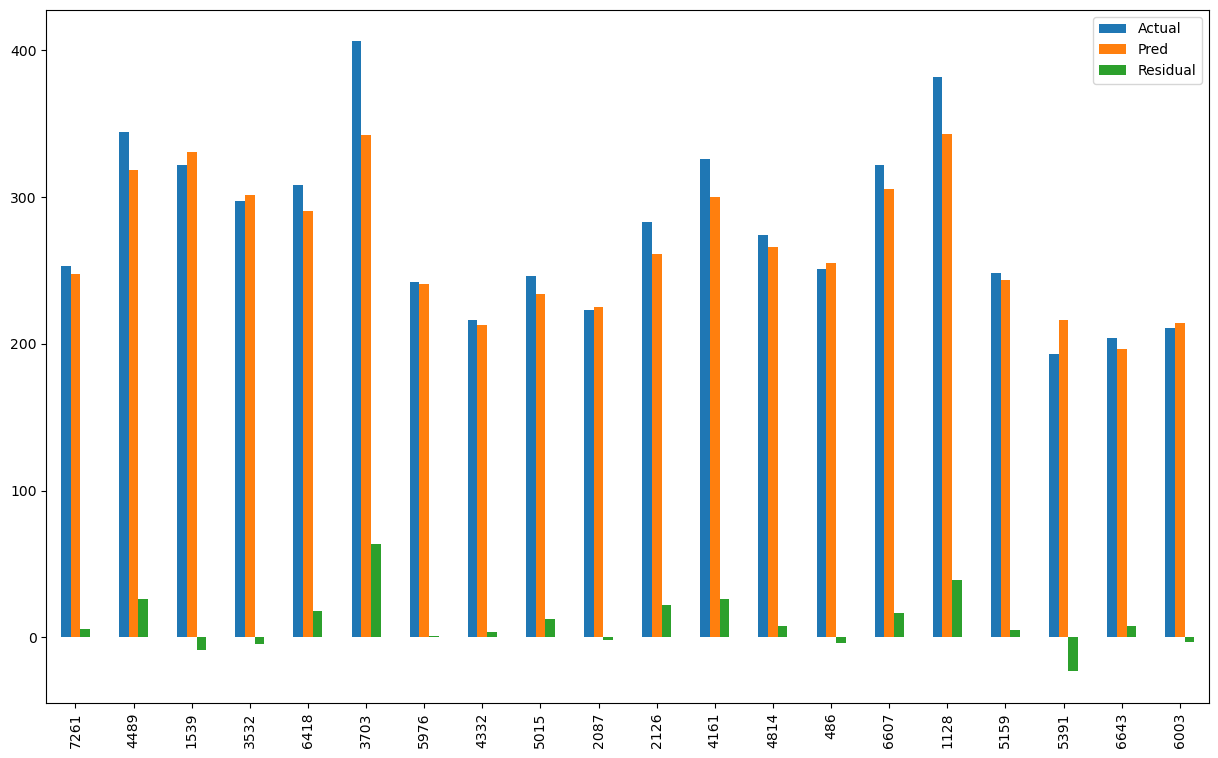

In [149]:
compare.head(20).plot(kind="bar", figsize = (15,9))
plt.show()

In [150]:
residual = y_test - y_test_pred
residual

7261     5.537578
4489    25.992178
1539    -8.680633
3532    -4.504436
6418    17.871345
          ...    
7185     5.121797
1740    20.326806
4609    -0.917724
1844    -9.982926
5154    -5.690803
Name: co2, Length: 1477, dtype: float64

In [151]:
plt.rcParams.update(plt.rcParamsDefault)

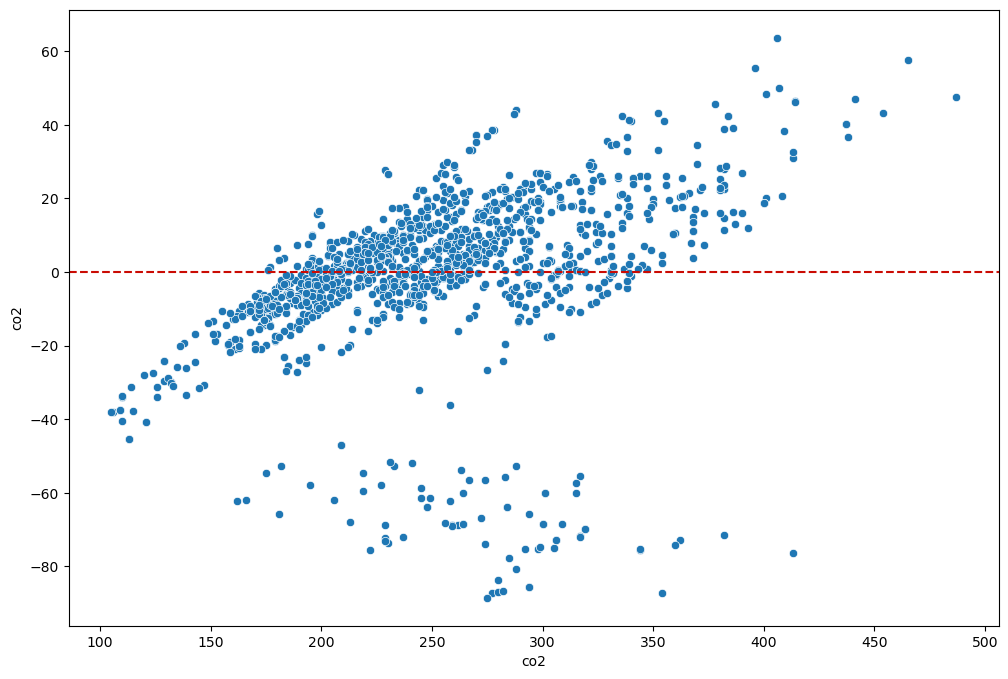

In [152]:

plt.figure(figsize = (12,8))
sns.scatterplot(x=y_test, y = residual)
plt.axhline(y=0, color="r", linestyle = "--")
plt.show()

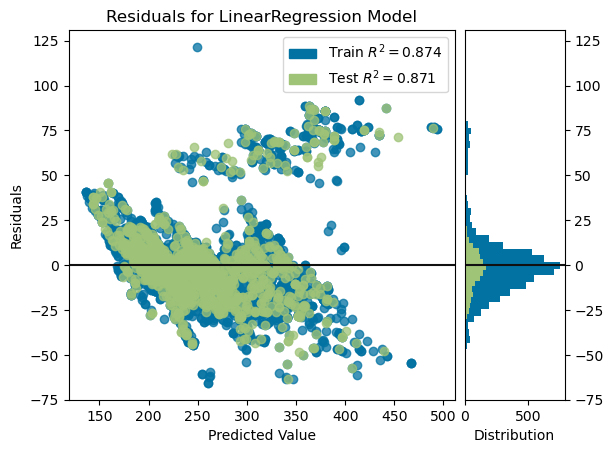

In [153]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show();

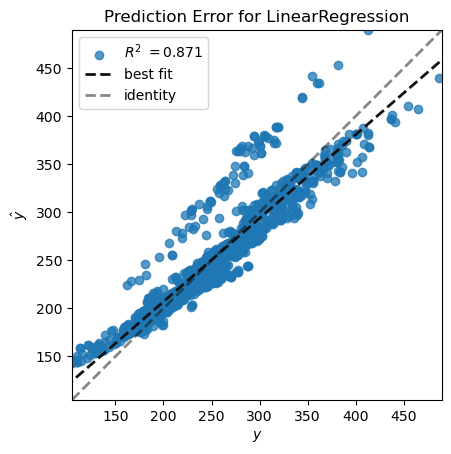

In [154]:
model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

In [155]:
# Multicolineratiy check

def color_correlation2(val):
    """
    Takes a scalar and returns a string with
    the css property in a variety of color scales 
    for different correlations.
    """
    if val >= 0.9 and val < 0.99999 or val <= -0.6 and val > -0.99999:
        color = 'red'
    elif val < 0.9 and val >= 0.3 or val > -0.6 and val <= -0.3:
        color = 'blue'
    elif val == 1:
        color = 'green'    
    else:
        color = 'black'
    return 'color: %s' % color
 
df.corr().style.applymap(color_correlation2)

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2
engine_size,1.000000,0.927653,0.831379,0.761526,0.817060,-0.757854,0.851145
cylinders,0.927653,1.000000,0.800702,0.715252,0.780534,-0.719321,0.832644
fuel_cons_city,0.831379,0.800702,1.000000,0.948180,0.993810,-0.927059,0.919592
fuel_cons_hwy,0.761526,0.715252,0.948180,1.000000,0.977299,-0.890638,0.883536
fuel_cons_comb,0.817060,0.780534,0.993810,0.977299,1.000000,-0.925576,0.918052
mpgfuel_cons_comb,-0.757854,-0.719321,-0.927059,-0.890638,-0.925576,1.000000,-0.907426
co2,0.851145,0.832644,0.919592,0.883536,0.918052,-0.907426,1.000000


## Final Model and Basic Predictions

In [160]:
X = df[["engine_size","fuel_cons_city","fuel_cons_hwy", "fuel_cons_comb"]]
y = df["co2"]

In [161]:
from sklearn.preprocessing import StandardScaler

In [162]:
scaler.fit(X)

StandardScaler()

In [163]:
X_scaled = scaler.transform(X)
X_scaled

array([[-0.85672099, -0.75900153, -1.05278069, -0.85574185],
       [-0.5613172 , -0.3875769 , -0.60320221, -0.47542306],
       [-1.22597573, -1.87327544, -1.45740132, -1.75467716],
       ...,
       [-0.85672099, -0.24472127, -0.19858158, -0.23340202],
       [-0.85672099, -0.3875769 , -0.33345513, -0.37169976],
       [-0.85672099, -0.10186564, -0.15362374, -0.09510428]])

In [164]:
final_model = LinearRegression()
final_model.fit(X_scaled,y)

LinearRegression()

In [158]:
engine_size = 2
fuel_cons_city = 9.9
fuel_cons_hwy = 6.7
fuel_cons_comb = 8.5

# olan aracin CO2 emisyonunu bulunuz.

X = np.array([[engine_size, fuel_cons_city, fuel_cons_hwy, fuel_cons_comb]])

X_scaled = scaler.transform(X)
X_scaled

CO2 = model.predict(X_scaled)

CO2 = np.squeeze(CO2).round(1)

print("Bu aracin CO2 salinimi %87 olasilikla", CO2, "g/Km civarindadir.")

Bu aracin CO2 salinimi %87 olasilikla 39.2 g/Km civarindadir.


In [159]:
df.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
